### マスキング(カラートラッキング＋モルフォロジー)

In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# BGR->HSV
def BGR2HSV(_img):
    img = _img.copy()/255
    
    hsv = np.zeros_like(img, dtype=np.float32)
    
    # get max and nim
    max_v = np.max(img, axis=2).copy()
    min_v = np.min(img, axis=2).copy()
    min_arg = np.argmin(img, axis=2)
    
    # H
    hsv[...,0][np.where(max_v==min_v)] = 0
    # if min == B
    ind = np.where(min_arg==0)
    hsv[...,0][ind] = 60*(img[...,1][ind] - img[..., 2][ind]) / (max_v[ind] - min_v[ind]) + 60
    # if min == R
    ind = np.where(min_arg==2)
    hsv[..., 0][ind] = 60*(img[...,0][ind] - img[..., 1][ind]) / (max_v[ind] - min_v[ind]) + 180
    # if min == G
    ind = np.where(min_arg==1)
    hsv[...,0][ind] = 60*(img[...,2][ind] - img[..., 0][ind]) / (max_v[ind] - min_v[ind]) +300
    
    # S
    hsv[..., 1] = max_v.copy() - min_v.copy()
    
    # V
    hsv[..., 2] = max_v.copy()
    
    return hsv

def get_mask(hsv):
    mask = np.zeros_like(hsv[...,0])
    mask[np.logical_and((hsv[..., 0]>180), (hsv[...,0]<260))] = 1
    return mask

def masking(img, mask):
    # これはブロードキャストできるのに
    mask = 1 - mask
    # 次は次元増やさずにやるとブロードキャストできないよってくる
    mask = np.expand_dims(mask, -1)
    out = np.zeros_like(img, dtype=np.uint8)
    # これでも可
    # mask = np.tile(mask, [3,1,1]).transpose([1,2,0])  
    out = mask * img
    
    # これがないと何故か白黒画像になる
    out = out.astype(np.uint8)
    return out

def Erosion(img, Erode_time=1):
    H,W = img.shape
    out = img.copy()
    
    # kernel
    MF = np.array(((0,1,0), (1,0,1), (0,1,0)), dtype=np.int)
    
    # earch erode
    for i in range(Erode_time):
        tmp = np.pad(out, (1,1), 'edge')
        # erode
        for y in range(1, H+1):
            for x in range(1, W+1):
                if np.sum(MF*tmp[y-1:y+2, x-1:x+2]) < 1*4:
                    out[y-1,x-1] = 0

    return out

def Dilate(img, Dil_time=1):
    H,W = img.shape
    out = img.copy()
    
    # kernel
    MF = np.array(((0,1,0),(1,0,1),(0,1,0)), dtype=np.int)
    
    # each dilation
    for i in range(Dil_time):
        tmp = np.pad(out, (1,1), 'edge')
        # dilate
        for y in range(1, H+1):
            for x in range(1, 1+W):
                if np.sum(MF*tmp[y-1:y+2, x-1:x+2])  > 0:
                    out[y-1, x-1] = 1
                    
    return out

def Morphology_Opening(img, time=1):
    out = Erosion(img, Erode_time=time)
    out = Dilate(out, Dil_time=time)
    return out

def Morphology_Closing(img, time=1):
    out = Dilate(img, Dil_time=time)
    out = Erosion(out, Erode_time=time)
    return out
    
    


True

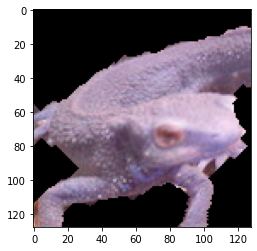

In [9]:
img = cv2.imread('../imori.jpg')
hsv = BGR2HSV(img)
mask = get_mask(hsv)
mask = Morphology_Closing(mask, time=5)
mask = Morphology_Opening(mask, time=5)
out = masking(img, mask)


plt.imshow(out)
cv2.imwrite('out72.jpg', out)